In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno    # 누락값 표시
import warnings
import mglearn
warnings.filterwarnings('ignore')  # dnjsld antl
from sklearn.model_selection import train_test_split
%matplotlib inline

# 비지도 변환 알고리즘

## 주성분 분석


### 차원 축소

In [8]:
from sklearn.datasets import load_breast_cancer
cancer =  load_breast_cancer()
X_train, X_test, y_train, y_test =  train_test_split(cancer.data, cancer.target, random_state=0)

Text(0, 0.5, 'second com')

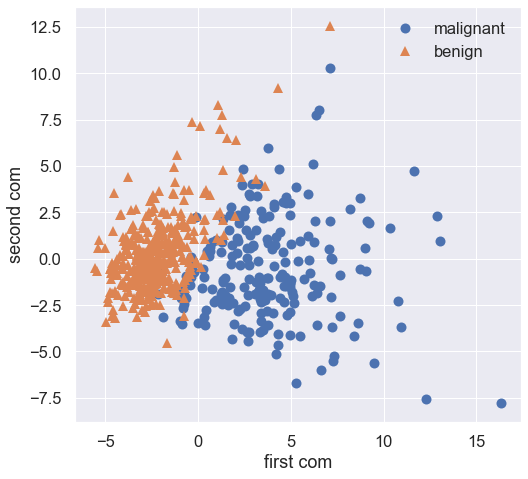

In [61]:
from sklearn.preprocessing import StandardScaler
# 특성의 스케일이 서로 다르면 올바른 주성분 방향을 찾을 수 없으니, PCA를 사용할 때는 표준값으로 바꿔야 한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)
from sklearn.decomposition import PCA
# 데이터의 처음 두 개의 주성분만 유지한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0], X_pca[:,1], cancer.target)
plt.legend(['malignant', 'benign'], loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('first com')
plt.ylabel('second com')

In [68]:
pca.components_

array([[ 0.21890244,  0.10372458,  0.22753729,  0.22099499,  0.14258969,
         0.23928535,  0.25840048,  0.26085376,  0.13816696,  0.06436335,
         0.20597878,  0.01742803,  0.21132592,  0.20286964,  0.01453145,
         0.17039345,  0.15358979,  0.1834174 ,  0.04249842,  0.10256832,
         0.22799663,  0.10446933,  0.23663968,  0.22487053,  0.12795256,
         0.21009588,  0.22876753,  0.25088597,  0.12290456,  0.13178394],
       [-0.23385713, -0.05970609, -0.21518136, -0.23107671,  0.18611302,
         0.15189161,  0.06016536, -0.0347675 ,  0.19034877,  0.36657547,
        -0.10555215,  0.08997968, -0.08945723, -0.15229263,  0.20443045,
         0.2327159 ,  0.19720728,  0.13032156,  0.183848  ,  0.28009203,
        -0.21986638, -0.0454673 , -0.19987843, -0.21935186,  0.17230435,
         0.14359317,  0.09796411, -0.00825724,  0.14188335,  0.27533947]])

Text(0, 0.5, 'Component')

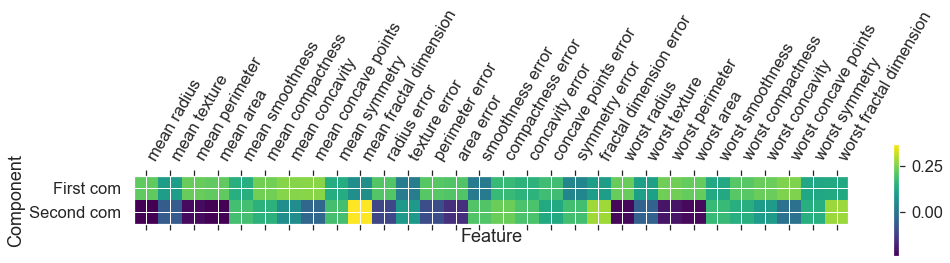

In [11]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First com', 'Second com'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),    
                cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Component')

### 특성 추출

In [60]:
# 데이터셋이 편중되어 있음을 확인

from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print('{0:25} {1:3}'.format(name, count), end='  ')
    if (i+1)%3 == 0:
        print()

Alejandro Toledo           39  Alvaro Uribe               35  Amelie Mauresmo            21  
Andre Agassi               36  Angelina Jolie             20  Ariel Sharon               77  
Arnold Schwarzenegger      42  Atal Bihari Vajpayee       24  Bill Clinton               29  
Carlos Menem               21  Colin Powell              236  David Beckham              31  
Donald Rumsfeld           121  George Robertson           22  George W Bush             530  
Gerhard Schroeder         109  Gloria Macapagal Arroyo    44  Gray Davis                 26  
Guillermo Coria            30  Hamid Karzai               22  Hans Blix                  39  
Hugo Chavez                71  Igor Ivanov                20  Jack Straw                 28  
Jacques Chirac             52  Jean Chretien              55  Jennifer Aniston           21  
Jennifer Capriati          42  Jennifer Lopez             21  Jeremy Greenstock          24  
Jiang Zemin                20  John Ashcroft              53

In [39]:
# 편중을 없애기 위해 사람마다 50개의 이미지만 선택
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]
# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 스케일로 조정한다.
X_people = X_people / 255.

In [48]:
# KNN Classifier로 얼굴 분류하기

from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
# 이웃 개수를 한 개로 하여 KNeighborsClassifier 모델을 만든다.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('test score:{:.2f}'.format(knn.score(X_test, y_test)))

test score:0.23


In [55]:
# pca 변환 후 다시 분류하기
                           # 화이트닝: 주성분의 스케일이 같아지도록 조정  
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

0.312015503875969

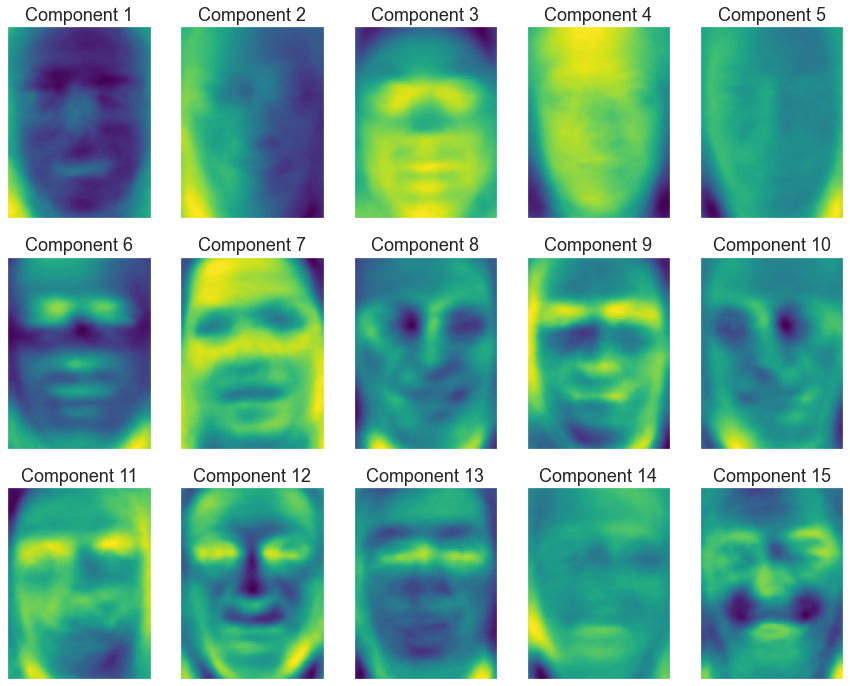

In [58]:
# 계산한 주성분 시각화하기

fig, ax = plt.subplots(3,5, figsize=(15,12),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(pca.components_, ax.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('Component {}'.format((i+1)))

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))
________________________________________________________pca_faces - 7.0s, 0.1min


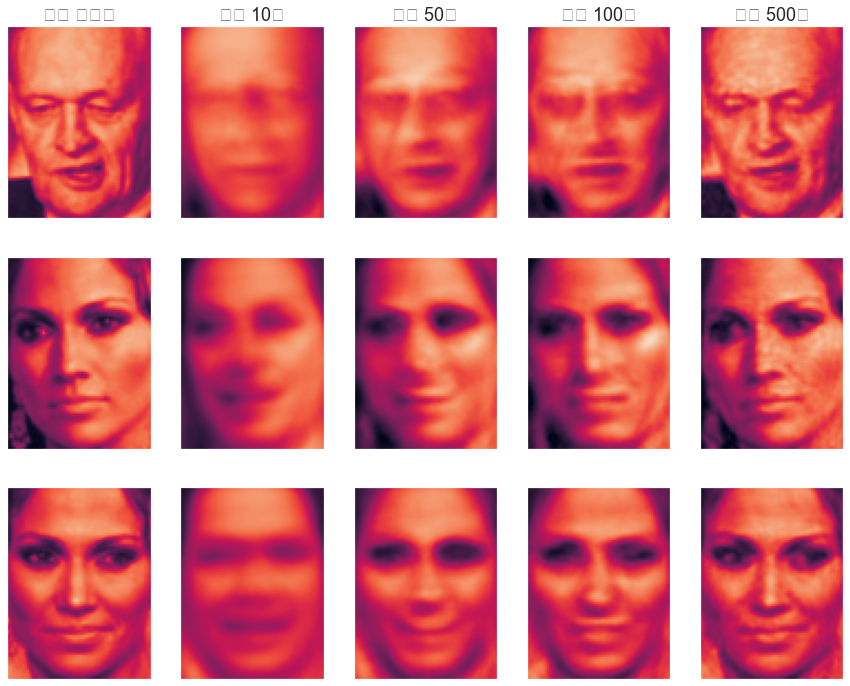

In [59]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

## 비음수 행렬 분해(NMF)

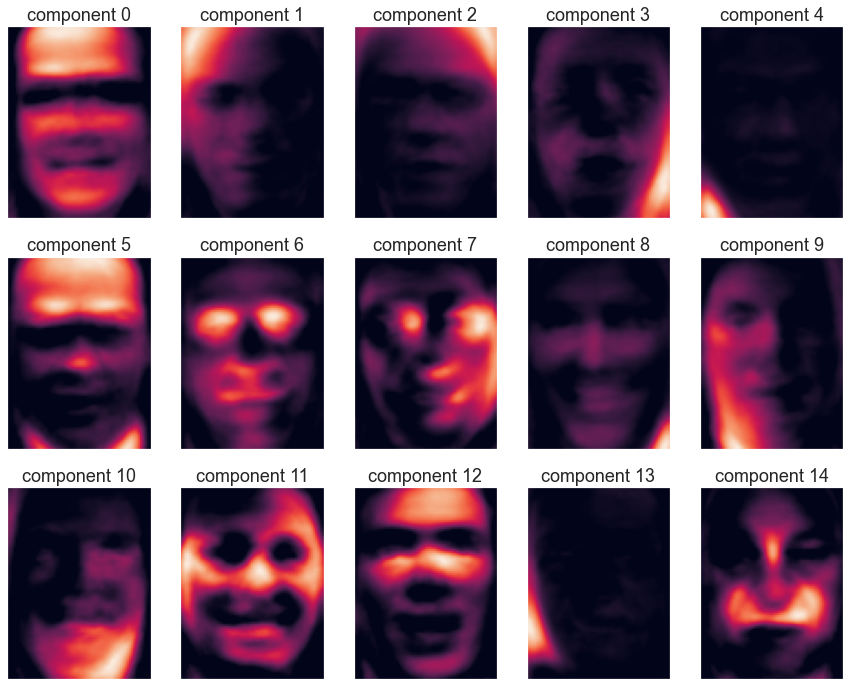

In [71]:
# 성분 15개 추출하기
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, ax = plt.subplots(3,5, figsize=(15,12),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(nmf.components_, ax.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title('component {}'.format(i))
    


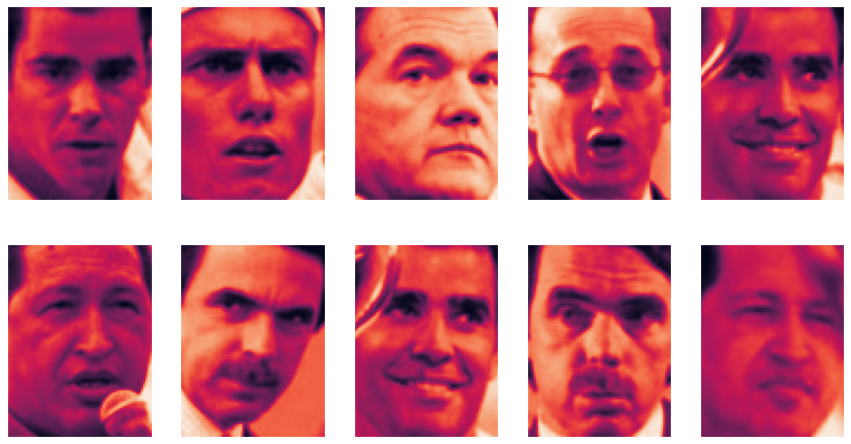

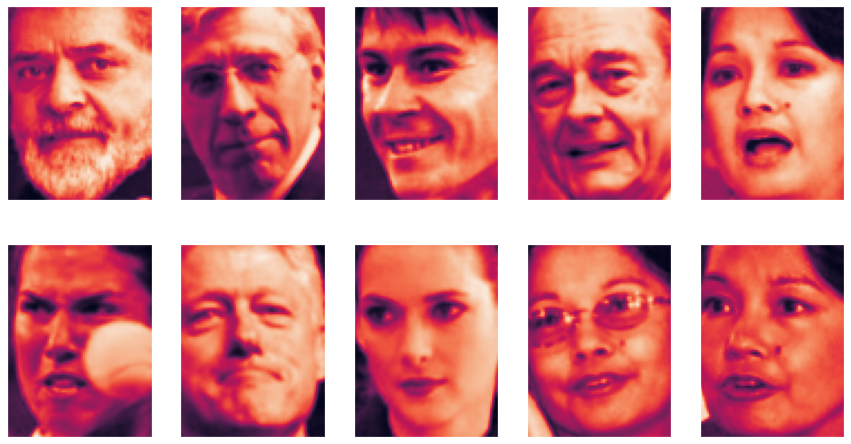

In [77]:
# 특정 성분이 강하게 나타난 이미지 확인하기
compn = 3

# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력한다.
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, ax = plt.subplots(2,5, figsize=(15,8),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (ind, ax) in enumerate(zip(inds, ax.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력한다.
compn = 7
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, ax = plt.subplots(2,5, figsize=(15,8),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (ind, ax) in enumerate(zip(inds, ax.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

## t_SNE(매니폴드 학습 알고리즘)

Text(0, 0.5, 't-SNE Feature 1')

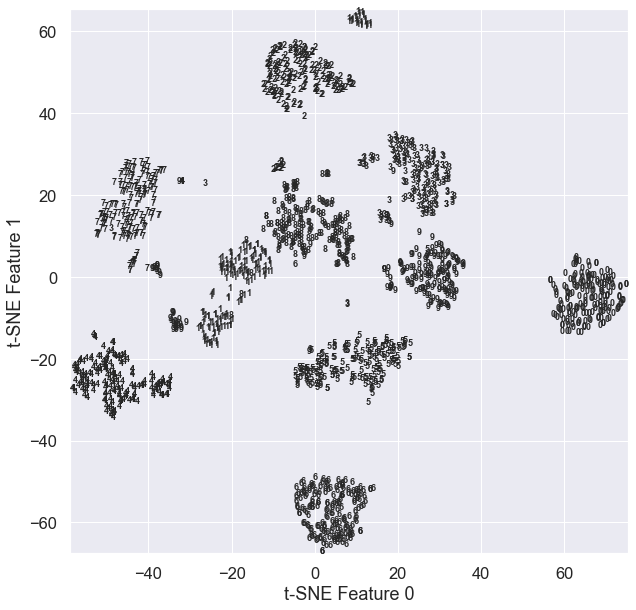

In [84]:
from sklearn.datasets import load_digits
digits = load_digits()
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10,10))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+1)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+1)
for i in range(len(digits.data)):
    # 숫자 텍스트를 이용해 산점도 그리기
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str(digits.target[i]),
             fontdict={'weight':'bold', 'size':9})
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

# 군집(Clustering)

### k-평균 군집(k-means Clustering)

In [92]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(random_state=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# KMeans로 만든 군집
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:,0],
kmeans.cluster_centers_[:,1], [0,1,2], markers='^', markeredgewidth=2)
plt.show()

KMeans(n_clusters=3)

Text(0.5, 1.0, 'cluster = 5')

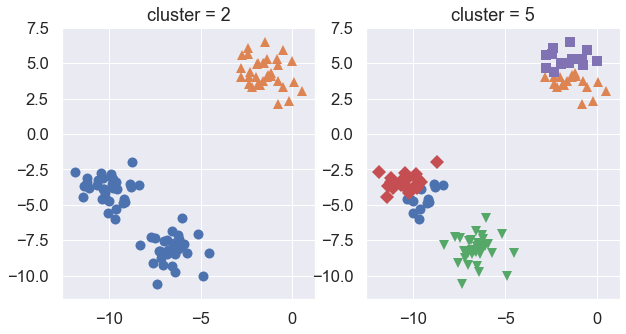

In [112]:
# 클러스터 수 바꾸기

f, ax = plt.subplots(1,2, figsize=(10,5))
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_
mglearn.discrete_scatter(X[:,0], X[:,1], assignments, ax=ax[0])
ax[0].set_title('cluster = 2')
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
assignments = kmeans.labels_
mglearn.discrete_scatter(X[:,0], X[:,1], assignments, ax=ax[1])
ax[1].set_title('cluster = 5')

### 병합 군집

In [125]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_test)

#### 덴드로그램 그리기

Text(0, 0.5, 'cluster dis')

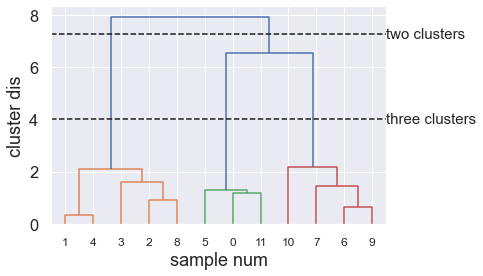

In [127]:
from scipy.cluster.hierarchy import dendrogram, ward

X,y = make_blobs(random_state=0, n_samples=12)
'''데이터 배열 X에 ward 함수를 적용한다.
Scipy의 ward 함수는 병합 군집을 수행할 때 생성된 거리 정보가 담긴 배열을 반환한다.'''
linkage_array = ward(X)
dendrogram(linkage_array)

# 두 개와 세 개의 클러스터를 구분하는 커트라인을 표시한다.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4,4], '--', c='k')

ax.text(bounds[1], 7.25, 'two clusters', va='center', fontdict={'size':15})
ax.text(bounds[1], 4, 'three clusters', va='center', fontdict={'size':15})
plt.xlabel('sample num')
plt.ylabel('cluster dis')

### DBSCAN

### 군집 알고리즘의 비교와 평가